In [64]:
import os
import pandas as pd

# Directories for checking empty files
NAIVE_DIR = "evaluation/rq4"              # For timebasic files
HORN_DIR = os.path.join("evaluation", "rq3", "random1000")  # For timehorn files

# -----------------------------
# Process execution_timebasic.csv
# -----------------------------
df_basic = pd.read_csv("execution_timebasic.csv")
df_basic = df_basic.rename(columns={"time_taken": "time_basic"})

def process_naive(row):
    """
    For each row, check if the corresponding file in NAIVE_DIR is empty.
    If empty or if the time is greater than 600, mark as "timeout".
    Otherwise, leave the numeric time.
    """
    # Build the expected filename: "crate_name-version"
    filename = f"{row['crate_name']}-{row['version']}"
    file_path = os.path.join(NAIVE_DIR, filename)
    
    # If file exists and is empty, mark as timeout
    if os.path.exists(file_path) and os.path.getsize(file_path) == 0:
        return "timeout"
    
    # Otherwise, check if the time exceeds 600
    try:
        t = float(row['time_basic'])
    except Exception:
        return row['time_basic']
    
    if t > 600:
        return "timeout"
    else:
        return t

df_basic["time_basic"] = df_basic.apply(process_naive, axis=1)

# Save the processed basic times to a new CSV file
df_basic.to_csv("execution_timebasic_timeout.csv", index=False)
print("Saved execution_timebasic_timeout.csv")

# -----------------------------
# Process execution_timeHorn.csv
# -----------------------------
df_horn = pd.read_csv("execution_timeHorn.csv")
df_horn = df_horn.rename(columns={"time_taken": "time_horn"})

def process_horn(row):
    """
    For each row, check if the corresponding file in HORN_DIR is empty.
    If empty or if the time is greater than 600, mark as "timeout".
    Otherwise, leave the numeric time.
    """
    # Build the expected filename: "crate_name-version"
    filename = f"{row['crate_name']}-{row['version']}"
    file_path = os.path.join(HORN_DIR, filename)
    
    # If file exists and is empty, mark as timeout
    if os.path.exists(file_path) and os.path.getsize(file_path) == 0:
        return "timeout"
    
    # Otherwise, check if the time exceeds 600
    try:
        t = float(row['time_horn'])
    except Exception:
        return row['time_horn']
    
    if t > 600:
        return "timeout"
    else:
        return t

df_horn["time_horn"] = df_horn.apply(process_horn, axis=1)

# Save the processed horn times to a new CSV file
df_horn.to_csv("execution_timeHorn_timeout.csv", index=False)
print("Saved execution_timeHorn_timeout.csv")


Saved execution_timebasic_timeout.csv
Saved execution_timeHorn_timeout.csv


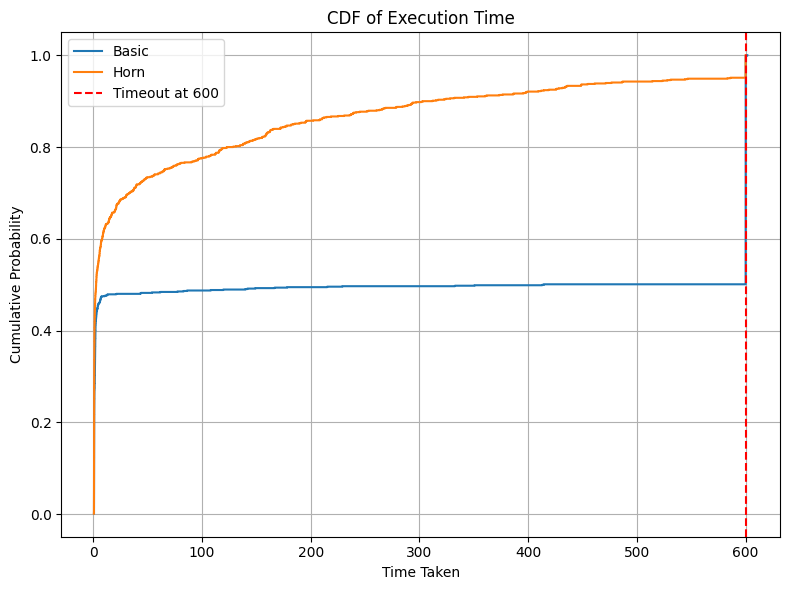

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read CSV files
df_basic = pd.read_csv("execution_timebasic.csv")
df_horn  = pd.read_csv("execution_timeHorn.csv")

# Sort the 'time_taken' values
times_basic = np.sort(df_basic['time_taken'])
times_horn  = np.sort(df_horn['time_taken'])

# Compute the CDF values
cdf_basic = np.arange(1, len(times_basic) + 1) / len(times_basic)
cdf_horn  = np.arange(1, len(times_horn) + 1) / len(times_horn)

# Create the plot
plt.figure(figsize=(8,6))
plt.step(times_basic, cdf_basic, label="Basic", where="post")
plt.step(times_horn, cdf_horn, label="Horn", where="post")

# Draw a vertical line at 600
plt.axvline(x=600, color='red', linestyle='--', label='Timeout at 600')

plt.xlabel("Time Taken")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Execution Time")
plt.grid(True)
plt.legend()
plt.tight_layout()

# plt.savefig("execution_time_cdf_timeout.pdf", bbox_inches="tight")
plt.show()


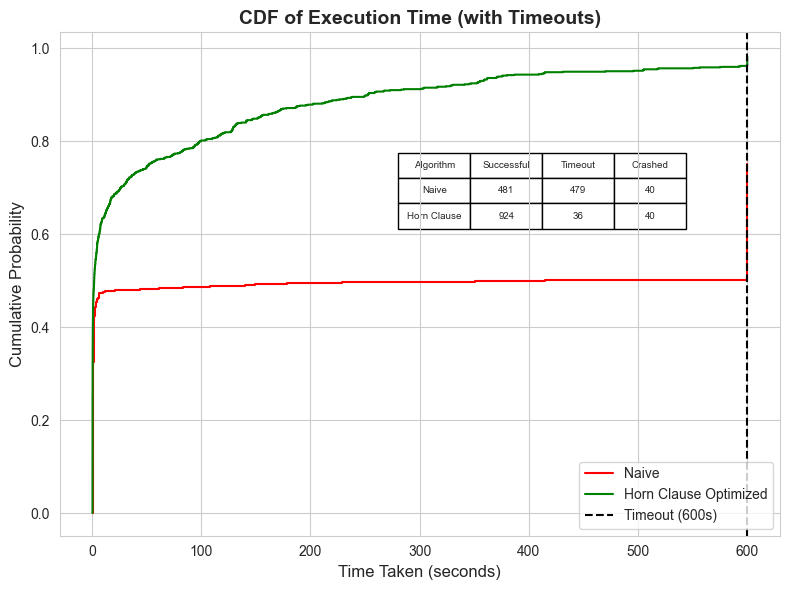

In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Timeout threshold
timeout_threshold = 600

# 1. Read the new CSV files (as strings to preserve "timeout")
df_basic = pd.read_csv("execution_timebasic_timeout.csv", dtype=str)
df_horn  = pd.read_csv("execution_timeHorn_timeout.csv", dtype=str)

# 2. Create numeric columns that convert non-timeout values to float and assign NaN for "timeout"
df_basic["numeric_time"] = df_basic["time_taken"].apply(lambda x: float(x) if x.strip().lower() != "timeout" else np.nan)
df_horn["numeric_time"]  = df_horn["time_taken"].apply(lambda x: float(x) if x.strip().lower() != "timeout" else np.nan)

# 3. For plotting, convert times: 
#    Replace NaN (which represent timeouts) with the timeout_threshold (600)
times_basic = np.sort(df_basic["numeric_time"].fillna(timeout_threshold).values)
times_horn  = np.sort(df_horn["numeric_time"].fillna(timeout_threshold).values)

# 4. Compute the CDFs
cdf_basic = np.arange(1, len(times_basic) + 1) / len(times_basic)
cdf_horn  = np.arange(1, len(times_horn)  + 1) / len(times_horn)

# 5. Outcome counts
# Count as "successful" if the numeric time exists and is less than timeout_threshold
success_basic = np.sum(df_basic["numeric_time"] < timeout_threshold)
# Count as "timeout" if the original string is "timeout" or numeric time is >= timeout_threshold
timeout_basic = np.sum((df_basic["time_taken"].str.lower() == "timeout") | (df_basic["numeric_time"] >= timeout_threshold))
crashed_basic = 40  # Replace with actual crash data if available

success_horn = np.sum(df_horn["numeric_time"] < timeout_threshold)
timeout_horn = np.sum((df_horn["time_taken"].str.lower() == "timeout") | (df_horn["numeric_time"] >= timeout_threshold))
crashed_horn = 40   # Replace with actual crash data if available

# 6. Create the figure and axes
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8,6))

# 7. Plot the CDF lines (using "steps-post" draw style)
sns.lineplot(x=times_basic, y=cdf_basic, drawstyle="steps-post", color="red",
             label="Naive", ax=ax)
sns.lineplot(x=times_horn, y=cdf_horn, drawstyle="steps-post", color="green",
             label="Horn Clause Optimized", ax=ax)

# Add a vertical line for the timeout threshold
ax.axvline(timeout_threshold, color="black", linestyle="--",
           label=f"Timeout ({timeout_threshold}s)")

ax.set_xlabel("Time Taken (seconds)", fontsize=12)
ax.set_ylabel("Cumulative Probability", fontsize=12)
ax.set_title("CDF of Execution Time (with Timeouts)", fontsize=14, fontweight="bold")
ax.legend(loc="lower right")

# 8. Create the table data with outcome counts
table_data = [
    ["Algorithm",   "Successful", "Timeout", "Crashed"],
    ["Naive",       success_basic, timeout_basic, crashed_basic],
    ["Horn Clause", success_horn,  timeout_horn,  crashed_horn]
]

the_table = ax.table(
    cellText=table_data,
    loc="upper right",   # adjust the bbox as needed
    cellLoc="center",
    bbox=[0.47, 0.61, 0.4, 0.15]  # [left, bottom, width, height]
)
the_table.scale(0.6, 1)
the_table.set_fontsize(9)

plt.tight_layout()
plt.savefig("/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq4/cdf_new.pdf", bbox_inches="tight")
plt.show()


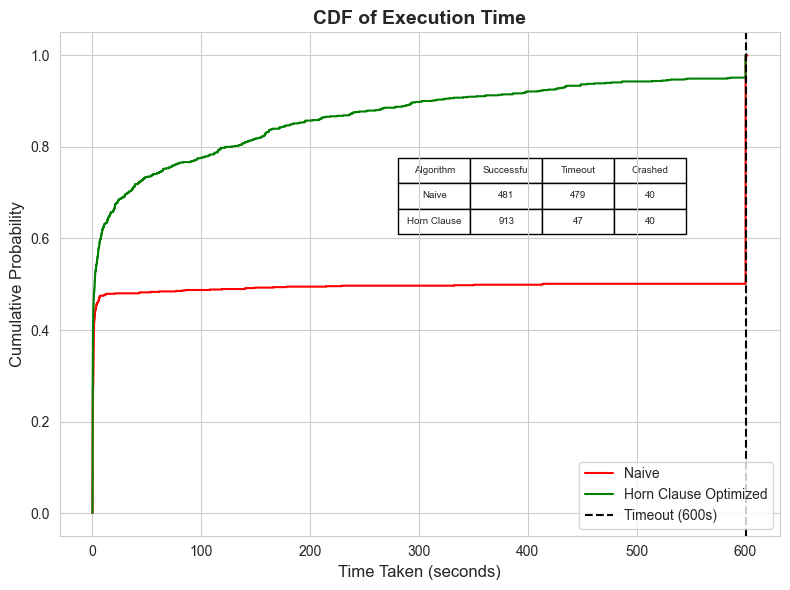

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Read your CSV files
df_basic = pd.read_csv("execution_timebasic.csv")
df_horn  = pd.read_csv("execution_timeHorn.csv")

# 2. Sort execution times
times_basic = np.sort(df_basic["time_taken"].values)
times_horn  = np.sort(df_horn["time_taken"].values)

# 3. Compute the CDF
cdf_basic = np.arange(1, len(times_basic) + 1) / len(times_basic)
cdf_horn  = np.arange(1, len(times_horn)  + 1) / len(times_horn)

# 4. Timeout threshold
timeout_threshold = 600

# 5. Outcome counts
success_basic = np.sum(times_basic < timeout_threshold)
timeout_basic = np.sum(times_basic >= timeout_threshold)
crashed_basic = 40  # or any crash data you have

success_horn = np.sum(times_horn < timeout_threshold)
timeout_horn = np.sum(times_horn >= timeout_threshold)
crashed_horn = 40   # or any crash data you have

# 6. Create the figure and axes FIRST
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8,6))

# 7. Plot the CDF lines
sns.lineplot(x=times_basic, y=cdf_basic, drawstyle="steps-post", color="red",
             label="Naive", ax=ax)
sns.lineplot(x=times_horn, y=cdf_horn, drawstyle="steps-post", color="green",
             label="Horn Clause Optimized", ax=ax)

# Add a vertical line for timeout
ax.axvline(timeout_threshold, color="black", linestyle="--",
           label=f"Timeout ({timeout_threshold}s)")

ax.set_xlabel("Time Taken (seconds)", fontsize=12)
ax.set_ylabel("Cumulative Probability", fontsize=12)
ax.set_title("CDF of Execution Time", fontsize=14, fontweight="bold")

# 8. Place the legend
ax.legend(loc="lower right")

# 9. Create the table data using your live values
table_data = [
    ["Algorithm",   "Successful", "Timeout", "Crashed"],
    ["Naive",       success_basic, timeout_basic, crashed_basic],
    ["Horn Clause", success_horn,  timeout_horn,  crashed_horn]
]

# 10. Add the table to the SAME Axes (ax). 
the_table = ax.table(
    cellText=table_data,
    loc="upper right",   # place in upper-right corner of the Axes
    cellLoc="center", 
    bbox=[0.47, 0.6, 0.4, 0.15],  # [left, bottom, width, height]
)

# Make the table a bit bigger or smaller as needed
the_table.scale(0.6, 1)
the_table.set_fontsize(9)


# Optionally hide top/right spines if they interfere
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig("/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq4/cdf.pdf", bbox_inches="tight")
plt.show()


JSON decode error in file serde-big-array-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 203)
JSON decode error in file markdown-0.3.0.json: Expecting property name enclosed in double quotes: line 11 column 1 (char 203)
JSON decode error in file mio-extras-2.0.6.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pipeline-0.5.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file glsl-layout-derive-0.4.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file lzma-sys-0.1.20.json: Expecting property name enclosed in double quotes: line 32 column 1 (char 601)
JSON decode error in file fail-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pickledb-0.5.1.json: Expecting property name enclosed in double quotes: line

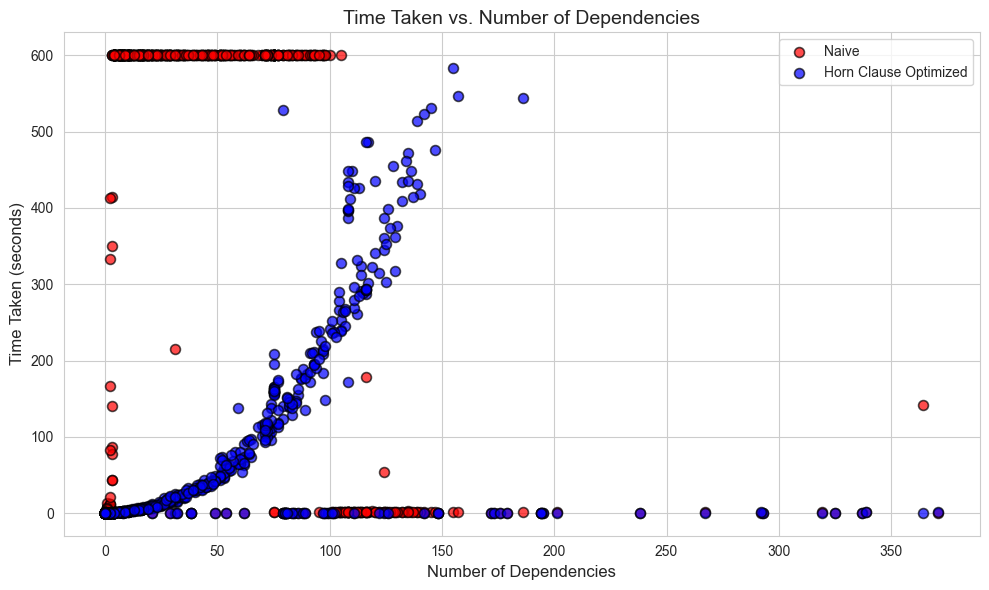

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Parse JSON files for dependency counts
# -----------------------------
CACHE_DIR = "logs/cache"  # Adjust path if needed
rows = []
failed_files = []  # List to hold names of JSON files that failed to parse

for filename in os.listdir(CACHE_DIR):
    if not filename.endswith(".json"):
        continue  # Skip non-JSON files
    path = os.path.join(CACHE_DIR, filename)
    
    # Assume filename format: "crate_name-version.json"
    base = filename[:-5]  # Remove ".json"
    if "-" in base:
        crate_name, crate_version = base.rsplit("-", 1)
    else:
        crate_name = base
        crate_version = "0.0.0"
    
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"JSON decode error in file {filename}: {e}")
        failed_files.append(filename)
        continue  # Skip this file
    
    # Get the dependency list and count them
    deps = data.get("dependencies", [])
    dep_count = len(deps)
    
    rows.append({
        "crate_name": crate_name,
        "version": crate_version,
        "dependency_count": dep_count
    })

df_deps = pd.DataFrame(rows)
print("Dependency counts extracted:")
print(df_deps.head())
if failed_files:
    print("The following files failed to parse and were skipped:")
    for f in failed_files:
        print(f)

# -----------------------------
# 2. Read timing CSV files for two algorithms
# -----------------------------
df_basic = pd.read_csv("execution_timebasic.csv")
df_basic = df_basic.rename(columns={"time_taken": "time_basic"})
# Expected columns: [crate_name, version, time_basic]

df_horn = pd.read_csv("execution_timeHorn.csv")
df_horn = df_horn.rename(columns={"time_taken": "time_horn"})
# Expected columns: [crate_name, version, time_horn]

# -----------------------------
# 3. Merge timing data and dependency counts
# -----------------------------
# Merge the two timing CSVs on crate_name and version (outer join to include all available data)
df_times = pd.merge(df_basic, df_horn, on=["crate_name", "version"], how="outer")
# Merge with dependency count data
df_merged = pd.merge(df_times, df_deps, on=["crate_name", "version"], how="left")

# Save combined CSV for future reference
df_merged.to_csv("data_with_deps_and_times.csv", index=False)
print("Merged data saved to data_with_deps_and_times.csv")
print(df_merged.head())

# -----------------------------
# 4. Remove outliers
# -----------------------------
# Remove rows where time_basic or time_horn exceeds the 95th percentile (if not NaN)
threshold_basic = df_merged["time_basic"].quantile(0.95)
threshold_horn  = df_merged["time_horn"].quantile(0.95)

df_filtered = df_merged[
    ((df_merged["time_basic"] <= threshold_basic) | (df_merged["time_basic"].isna())) &
    ((df_merged["time_horn"]  <= threshold_horn)  | (df_merged["time_horn"].isna()))
]
print("Data after outlier removal:")
print(df_filtered.head())

# -----------------------------
# 5. Plot a scatter chart: Dependency count vs. Time Taken (filtered data)
# -----------------------------
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10,6))

# Scatter plot for Basic approach in red
ax.scatter(
    df_filtered["dependency_count"],
    df_filtered["time_basic"],
    color="red",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Naive"
)

# Scatter plot for Horn approach in blue
ax.scatter(
    df_filtered["dependency_count"],
    df_filtered["time_horn"],
    color="blue",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Horn Clause Optimized"
)

ax.set_xlabel("Number of Dependencies", fontsize=12)
ax.set_ylabel("Time Taken (seconds)", fontsize=12)
ax.set_title("Time Taken vs. Number of Dependencies", fontsize=14)
ax.legend()

plt.tight_layout()
plt.savefig("/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq4/scatter.pdf", bbox_inches="tight")
plt.show()


In [ ]:
import pandas as pd

df_deps = pd.read_csv("data_with_deps_and_times.csv")
# Filter for crates with 200 or more dependencies
high_dep_crates = df_deps[df_deps["dependency_count"] >= 200]
print(high_dep_crates[["crate_name", "version", "dependency_count"]])


Crates with 200+ dependencies:
                  crate_name  version  dependency_count
91              bellhop-demo    0.2.1             201.0
124          bevy_ldtk_asset    0.6.4             214.0
221               deathframe    0.5.1             293.0
388                 gweiyser    0.1.4             227.0
443                     iroh   0.34.0             292.0
444                 iroh-api    0.2.0             210.0
448               iroh-blobs   0.34.0             319.0
451                 iroh-cli   0.28.1             364.0
452          iroh-dns-server   0.34.0             238.0
453                iroh-docs   0.34.0             325.0
454              iroh-doctor   0.33.0             337.0
455               iroh-embed    0.2.0             311.0
495                 migrator    0.1.0             206.0
577                     neo3    0.1.9             267.0
622           photon-indexer   0.50.0             626.0
652                   picahq    0.1.1             318.0
770              

In [27]:
threshold_basic = df_merged["time_basic"].quantile(0.95)
print("95th percentile for Basic:", threshold_basic)


95th percentile for Basic: 600.057812491816


In [28]:
df_merged[df_merged["dependency_count"] > 100].sort_values("dependency_count", ascending=False)
df_merged

,crate_name,version,time_basic,time_horn,dependency_count
0,agave-librapay-api,0.1.0,0.809032,0.665015,0.0
1,agave-loader-v4-program,0.1.0,0.693730,0.660973,0.0
2,agave-local-cluster,0.1.0,0.712956,0.723543,0.0
3,agave-logger,0.1.0,0.684772,0.604826,0.0
4,agave-lualoader,0.1.0,0.701251,0.665164,0.0
...,...,...,...,...,...
955,yew-virtualized,0.2.0,600.011749,118.720100,72.0
956,yew-websocket,1.21.0,600.033975,150.806487,81.0
957,yew-webtransport,0.21.1,600.018104,134.860121,77.0
958,yew_assets,0.1.2,600.026078,108.523697,71.0


JSON decode error in file serde-big-array-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 203)
JSON decode error in file markdown-0.3.0.json: Expecting property name enclosed in double quotes: line 11 column 1 (char 203)
JSON decode error in file mio-extras-2.0.6.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pipeline-0.5.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file glsl-layout-derive-0.4.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file lzma-sys-0.1.20.json: Expecting property name enclosed in double quotes: line 32 column 1 (char 601)
JSON decode error in file fail-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pickledb-0.5.1.json: Expecting property name enclosed in double quotes: line

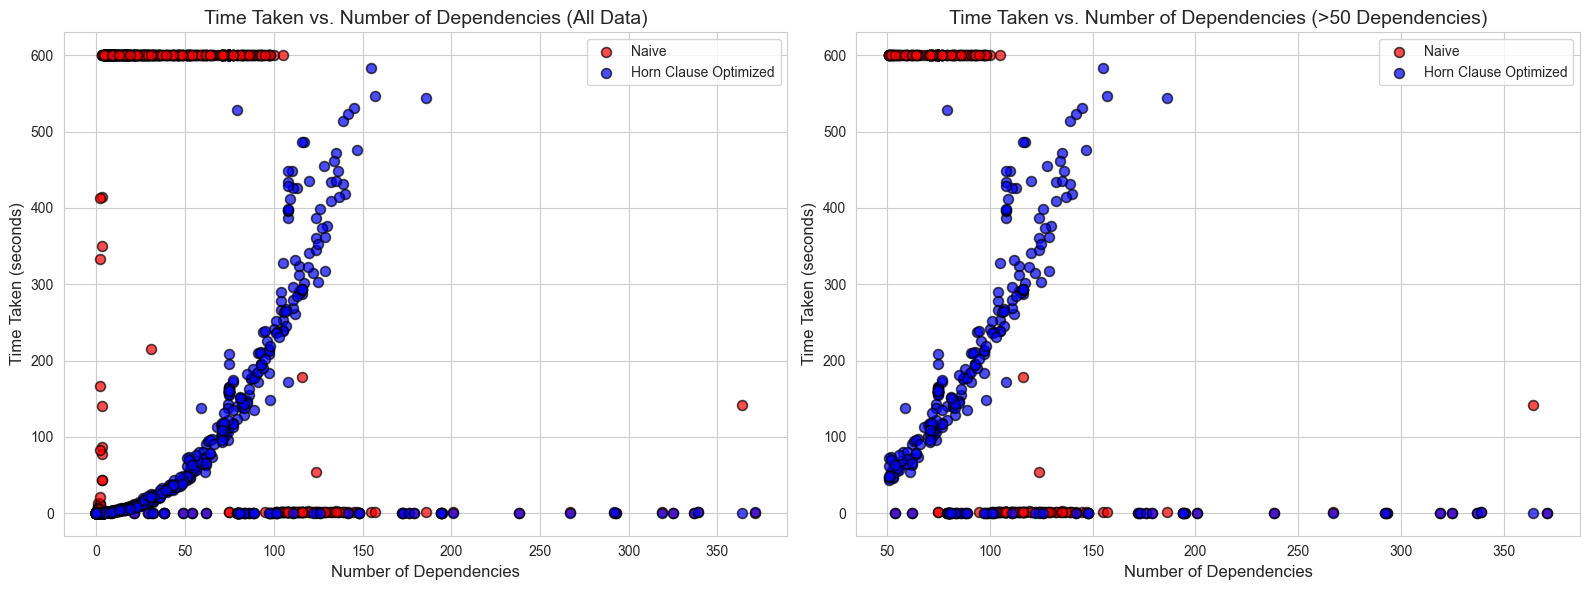

High Dependency Projects (>50 dependencies):
          crate_name  version  dependency_count  time_basic  time_horn
835    solana-tokens    2.2.3             371.0    0.835535   1.040119
451         iroh-cli   0.28.1             364.0  141.683157   0.939598
813   solana-install  1.18.26             339.0    1.514938   1.193974
454      iroh-doctor   0.33.0             337.0    0.765522   0.824348
453        iroh-docs   0.34.0             325.0    0.774653   0.716393
448       iroh-blobs   0.34.0             319.0    1.040699   0.991342
221       deathframe    0.5.1             293.0    0.930642   0.818624
443             iroh   0.34.0             292.0    0.984011   1.031215
577             neo3    0.1.9             267.0    1.255725   0.933331
452  iroh-dns-server   0.34.0             238.0    0.938010   0.832625


In [43]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Parse JSON files for dependency counts
# -----------------------------
CACHE_DIR = "logs/cache"  # Adjust path if needed
rows = []
failed_files = []  # List to hold names of JSON files that failed to parse

for filename in os.listdir(CACHE_DIR):
    if not filename.endswith(".json"):
        continue  # Skip non-JSON files
    path = os.path.join(CACHE_DIR, filename)
    
    # Assume filename format: "crate_name-version.json"
    base = filename[:-5]  # Remove ".json"
    if "-" in base:
        crate_name, crate_version = base.rsplit("-", 1)
    else:
        crate_name = base
        crate_version = "0.0.0"
    
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"JSON decode error in file {filename}: {e}")
        failed_files.append(filename)
        continue  # Skip this file
    
    # Get the dependency list and count them
    deps = data.get("dependencies", [])
    dep_count = len(deps)
    
    rows.append({
        "crate_name": crate_name,
        "version": crate_version,
        "dependency_count": dep_count
    })

df_deps = pd.DataFrame(rows)

# -----------------------------
# 2. Read timing CSV files for two algorithms
# -----------------------------
df_basic = pd.read_csv("execution_timebasic.csv")
df_basic = df_basic.rename(columns={"time_taken": "time_basic"})

df_horn = pd.read_csv("execution_timeHorn.csv")
df_horn = df_horn.rename(columns={"time_taken": "time_horn"})

# -----------------------------
# 3. Merge timing data and dependency counts
# -----------------------------
df_times = pd.merge(df_basic, df_horn, on=["crate_name", "version"], how="outer")
df_merged = pd.merge(df_times, df_deps, on=["crate_name", "version"], how="left")

# -----------------------------
# 4. Remove outliers and filter for higher dependencies
# -----------------------------
threshold_basic = df_merged["time_basic"].quantile(0.95)
threshold_horn = df_merged["time_horn"].quantile(0.95)

df_filtered = df_merged[
    ((df_merged["time_basic"] <= threshold_basic) | (df_merged["time_basic"].isna())) &
    ((df_merged["time_horn"] <= threshold_horn) | (df_merged["time_horn"].isna()))
]

# Filter for projects with more than 50 dependencies
df_high_deps = df_filtered[df_filtered["dependency_count"] > 50]

# -----------------------------
# 5. Plot scatter charts
# -----------------------------
sns.set_style("whitegrid")

# Plot for all data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

# All data scatter plot
ax1.scatter(
    df_filtered["dependency_count"],
    df_filtered["time_basic"],
    color="red",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Naive"
)
ax1.scatter(
    df_filtered["dependency_count"],
    df_filtered["time_horn"],
    color="blue",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Horn Clause Optimized"
)
ax1.set_xlabel("Number of Dependencies", fontsize=12)
ax1.set_ylabel("Time Taken (seconds)", fontsize=12)
ax1.set_title("Time Taken vs. Number of Dependencies (All Data)", fontsize=14)
ax1.legend()

# High dependencies scatter plot
ax2.scatter(
    df_high_deps["dependency_count"],
    df_high_deps["time_basic"],
    color="red",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Naive"
)
ax2.scatter(
    df_high_deps["dependency_count"],
    df_high_deps["time_horn"],
    color="blue",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Horn Clause Optimized"
)
ax2.set_xlabel("Number of Dependencies", fontsize=12)
ax2.set_ylabel("Time Taken (seconds)", fontsize=12)
ax2.set_title("Time Taken vs. Number of Dependencies (>50 Dependencies)", fontsize=14)
ax2.legend()

plt.tight_layout()
# plt.savefig("/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq4/scatter_high_deps.pdf", bbox_inches="tight")
plt.show()

# Print some statistics about high dependency projects
print("High Dependency Projects (>50 dependencies):")
print(df_high_deps[["crate_name", "version", "dependency_count", "time_basic", "time_horn"]].sort_values("dependency_count", ascending=False).head(10))

In [53]:
import pandas as pd
import numpy as np

# Assuming you have the merged dataframe from previous code
# Filter for high dependency projects
df_high_deps = df_merged[df_merged["dependency_count"] > 50]

# Identify projects with blue points but missing red points
blue_only_projects = df_high_deps[
    (df_high_deps["time_horn"].notna()) & 
    (df_high_deps["time_basic"].isna())
]

print("Projects with Horn Clause times but no Naive approach times:")
print(blue_only_projects[["crate_name", "version", "dependency_count", "time_horn"]])

# Print a summary of high dependency projects
print("\nSummary of High Dependency Projects:")
summary = df_high_deps.groupby(pd.cut(df_high_deps["dependency_count"], bins=[50, 100, 200, 300, np.inf])).agg({
    "crate_name": "count",
    "time_basic": ["mean", "count"],
    "time_horn": ["mean", "count"]
})
print(summary)

Projects with Horn Clause times but no Naive approach times:
Empty DataFrame
Columns: [crate_name, version, dependency_count, time_horn]
Index: []

Summary of High Dependency Projects:
                 crate_name  time_basic         time_horn      
                      count        mean count        mean count
dependency_count                                               
(50.0, 100.0]           154  518.310438   154   91.243815   154
(100.0, 200.0]          118   11.616861   118  316.576857   118
(200.0, 300.0]           16    2.336459    16  412.756208    16
(300.0, inf]             16   53.078552    16  337.888263    16


/var/folders/lq/4jp2ndl57996typyw791t0x00000gn/T/ipykernel_28898/687212045.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_high_deps.groupby(pd.cut(df_high_deps["dependency_count"], bins=[50, 100, 200, 300, np.inf])).agg({


JSON decode error in file serde-big-array-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 203)
JSON decode error in file markdown-0.3.0.json: Expecting property name enclosed in double quotes: line 11 column 1 (char 203)
JSON decode error in file mio-extras-2.0.6.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pipeline-0.5.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file glsl-layout-derive-0.4.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file lzma-sys-0.1.20.json: Expecting property name enclosed in double quotes: line 32 column 1 (char 601)
JSON decode error in file fail-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pickledb-0.5.1.json: Expecting property name enclosed in double quotes: line

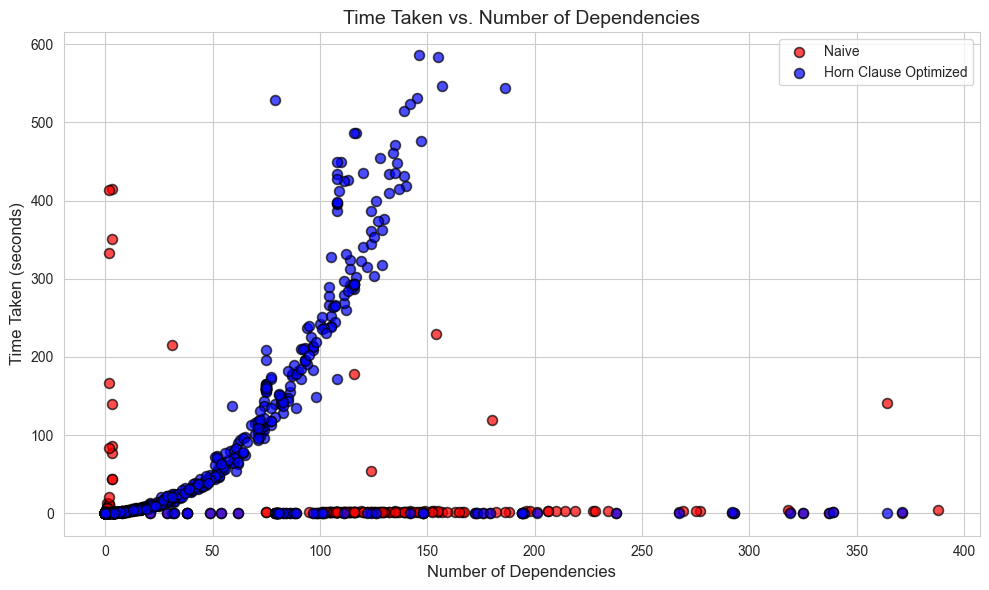

In [58]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Parse JSON files for dependency counts
# -----------------------------
CACHE_DIR = "logs/cache"  # Adjust path if needed
rows = []
failed_files = []  # List to hold names of JSON files that failed to parse

for filename in os.listdir(CACHE_DIR):
    if not filename.endswith(".json"):
        continue  # Skip non-JSON files
    path = os.path.join(CACHE_DIR, filename)
    
    # Assume filename format: "crate_name-version.json"
    base = filename[:-5]  # Remove ".json"
    if "-" in base:
        crate_name, crate_version = base.rsplit("-", 1)
    else:
        crate_name = base
        crate_version = "0.0.0"
    
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"JSON decode error in file {filename}: {e}")
        failed_files.append(filename)
        continue  # Skip this file
    
    # Get the dependency list and count them
    deps = data.get("dependencies", [])
    dep_count = len(deps)
    
    rows.append({
        "crate_name": crate_name,
        "version": crate_version,
        "dependency_count": dep_count
    })

df_deps = pd.DataFrame(rows)
print("Dependency counts extracted:")
print(df_deps.head())
if failed_files:
    print("The following files failed to parse and were skipped:")
    for f in failed_files:
        print(f)

# -----------------------------
# 2. Read timing CSV files for two algorithms
# -----------------------------
df_basic = pd.read_csv("execution_timebasic.csv")
df_basic = df_basic.rename(columns={"time_taken": "time_basic"})
# Expected columns: [crate_name, version, time_basic]

df_horn = pd.read_csv("execution_timeHorn.csv")
df_horn = df_horn.rename(columns={"time_taken": "time_horn"})
# Expected columns: [crate_name, version, time_horn]

# -----------------------------
# 3. Merge timing data and dependency counts
# -----------------------------
df_times = pd.merge(df_basic, df_horn, on=["crate_name", "version"], how="outer")
df_merged = pd.merge(df_times, df_deps, on=["crate_name", "version"], how="left")

# Save combined CSV for future reference
df_merged.to_csv("data_with_deps_and_times.csv", index=False)
print("Merged data saved to data_with_deps_and_times.csv")
print(df_merged.head())

# -----------------------------
# 4. Filter data for plotting
# -----------------------------
# First, remove crates with more than 400 dependencies
# df_filtered = df_merged[df_merged["dependency_count"] <= 400]

# For Naive approach: only plot points where time_basic is 600 or less
df_naive_plot = df_filtered[df_filtered["time_basic"] <= 600]


# For Horn Clause Optimized approach: only plot points where time_horn is 600 or less
df_horn_plot = df_filtered[df_filtered["time_horn"] <= 600]

print("Naive data for plotting:")
print(df_naive_plot.head())
print("Horn Clause Optimized data for plotting:")
print(df_horn_plot.head())

# -----------------------------
# 5. Plot a scatter chart: Dependency count vs. Time Taken
# -----------------------------
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot for Naive approach (red)
ax.scatter(
    df_naive_plot["dependency_count"],
    df_naive_plot["time_basic"],
    color="red",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Naive"
)

# Scatter plot for Horn Clause Optimized approach (blue)
ax.scatter(
    df_horn_plot["dependency_count"],
    df_horn_plot["time_horn"],
    color="blue",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Horn Clause Optimized"
)

ax.set_xlabel("Number of Dependencies", fontsize=12)
ax.set_ylabel("Time Taken (seconds)", fontsize=12)
ax.set_title("Time Taken vs. Number of Dependencies", fontsize=14)
ax.legend()

plt.tight_layout()
# plt.savefig("/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq4/scatter.pdf", bbox_inches="tight")
plt.show()


JSON decode error in file serde-big-array-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 203)
JSON decode error in file markdown-0.3.0.json: Expecting property name enclosed in double quotes: line 11 column 1 (char 203)
JSON decode error in file mio-extras-2.0.6.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pipeline-0.5.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file glsl-layout-derive-0.4.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file lzma-sys-0.1.20.json: Expecting property name enclosed in double quotes: line 32 column 1 (char 601)
JSON decode error in file fail-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pickledb-0.5.1.json: Expecting property name enclosed in double quotes: line

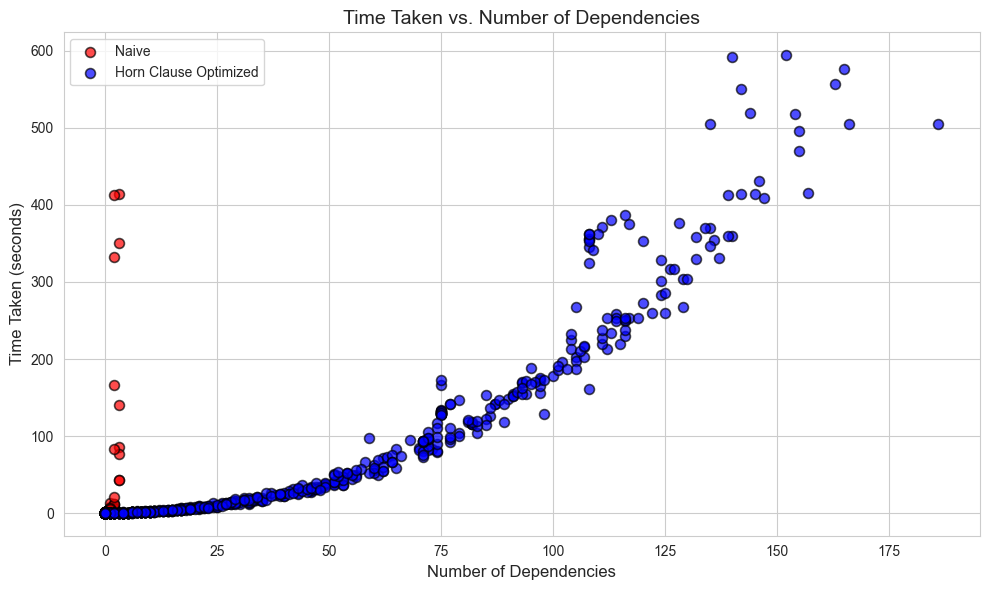

In [82]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Parse JSON files for dependency counts
# -----------------------------
CACHE_DIR = "logs/cache"  # Adjust path if needed
rows = []
failed_files = []  # List to hold names of JSON files that failed to parse

for filename in os.listdir(CACHE_DIR):
    if not filename.endswith(".json"):
        continue  # Skip non-JSON files
    path = os.path.join(CACHE_DIR, filename)
    
    # Assume filename format: "crate_name-version.json"
    base = filename[:-5]  # Remove ".json"
    if "-" in base:
        crate_name, crate_version = base.rsplit("-", 1)
    else:
        crate_name = base
        crate_version = "0.0.0"
    
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"JSON decode error in file {filename}: {e}")
        failed_files.append(filename)
        continue  # Skip this file
    
    # Get the dependency list and count them
    deps = data.get("dependencies", [])
    dep_count = len(deps)
    
    rows.append({
        "crate_name": crate_name,
        "version": crate_version,
        "dependency_count": dep_count
    })

df_deps = pd.DataFrame(rows)
print("Dependency counts extracted:")
print(df_deps.head())
if failed_files:
    print("The following files failed to parse and were skipped:")
    for f in failed_files:
        print(f)

# -----------------------------
# 2. Read timing CSV files for two algorithms (new files with timeout values)
# -----------------------------
# We assume the new CSV files are:
#   - "execution_timebasic_timeout.csv" for the Naive approach,
#   - "execution_timeHorn_timeout.csv" for the Horn Clause approach.
df_basic = pd.read_csv("execution_timebasic_timeout.csv", dtype=str)
df_basic = df_basic.rename(columns={"time_taken": "time_basic"})

df_horn = pd.read_csv("execution_timeHorn_timeout.csv", dtype=str)
df_horn = df_horn.rename(columns={"time_taken": "time_horn"})

# -----------------------------
# 3. Merge timing data and dependency counts
# -----------------------------
df_times = pd.merge(df_basic, df_horn, on=["crate_name", "version"], how="outer")
df_merged = pd.merge(df_times, df_deps, on=["crate_name", "version"], how="left")

# Save merged data for future reference
df_merged.to_csv("data_with_deps_and_times_new.csv", index=False)
print("Merged data saved to data_with_deps_and_times_new.csv")
print(df_merged.head())

# -----------------------------
# 4. Convert time columns to numeric (turning "timeout" into NaN)
# -----------------------------
df_merged["time_basic_numeric"] = pd.to_numeric(df_merged["time_basic"], errors='coerce')
df_merged["time_horn_numeric"]  = pd.to_numeric(df_merged["time_horn"], errors='coerce')

# -----------------------------
# 5. Filter data: Only keep rows with <= 400 dependencies.
# -----------------------------
df_filtered = df_merged[df_merged["dependency_count"] <= 400]

# Create separate datasets for each algorithm:
df_plot_basic = df_filtered[df_filtered["time_basic_numeric"].notna()].copy()
df_plot_horn  = df_filtered[df_filtered["time_horn_numeric"].notna()].copy()

# -----------------------------
# 6. Drop rows where the corresponding file has only one line.
# -----------------------------
NAIVE_DIR = "evaluation/rq4"  # Directory for Naive approach files
HORN_DIR = os.path.join("evaluation", "rq3", "random1000")  # Directory for Horn Clause files

def file_has_more_than_one_line(directory, crate_name, version):
    filename = f"{crate_name}-{version}"
    file_path = os.path.join(directory, filename)
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            lines = f.readlines()
        return len(lines) > 1
    # If file does not exist, we assume it's valid for plotting
    return True

# Filter for Naive dataset: keep only if the corresponding file has >1 line.
df_plot_basic = df_plot_basic[df_plot_basic.apply(
    lambda row: file_has_more_than_one_line(NAIVE_DIR, row["crate_name"], row["version"]), axis=1
)]

# Filter for Horn Clause dataset: keep only if the corresponding file has >1 line.
df_plot_horn = df_plot_horn[df_plot_horn.apply(
    lambda row: file_has_more_than_one_line(HORN_DIR, row["crate_name"], row["version"]), axis=1
)]

print("Filtered data for Naive plotting:")
print(df_plot_basic.head())
print("Filtered data for Horn Clause plotting:")
print(df_plot_horn.head())

# -----------------------------
# 7. Plot a scatter chart: Dependency count vs. Time Taken (only numeric values per algorithm)
# -----------------------------
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,6))

# Scatter plot for Naive approach (red)
ax.scatter(
    df_plot_basic["dependency_count"],
    df_plot_basic["time_basic_numeric"],
    color="red",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Naive"
)

# Scatter plot for Horn Clause Optimized approach (blue)
ax.scatter(
    df_plot_horn["dependency_count"],
    df_plot_horn["time_horn_numeric"],
    color="blue",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Horn Clause Optimized"
)

ax.set_xlabel("Number of Dependencies", fontsize=12)
ax.set_ylabel("Time Taken (seconds)", fontsize=12)
ax.set_title("Time Taken vs. Number of Dependencies", fontsize=14)
ax.legend()

plt.tight_layout()
plt.savefig("/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq4/scatter.pdf", bbox_inches="tight")
plt.show()


JSON decode error in file serde-big-array-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 203)
JSON decode error in file markdown-0.3.0.json: Expecting property name enclosed in double quotes: line 11 column 1 (char 203)
JSON decode error in file mio-extras-2.0.6.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pipeline-0.5.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file glsl-layout-derive-0.4.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file lzma-sys-0.1.20.json: Expecting property name enclosed in double quotes: line 32 column 1 (char 601)
JSON decode error in file fail-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pickledb-0.5.1.json: Expecting property name enclosed in double quotes: line

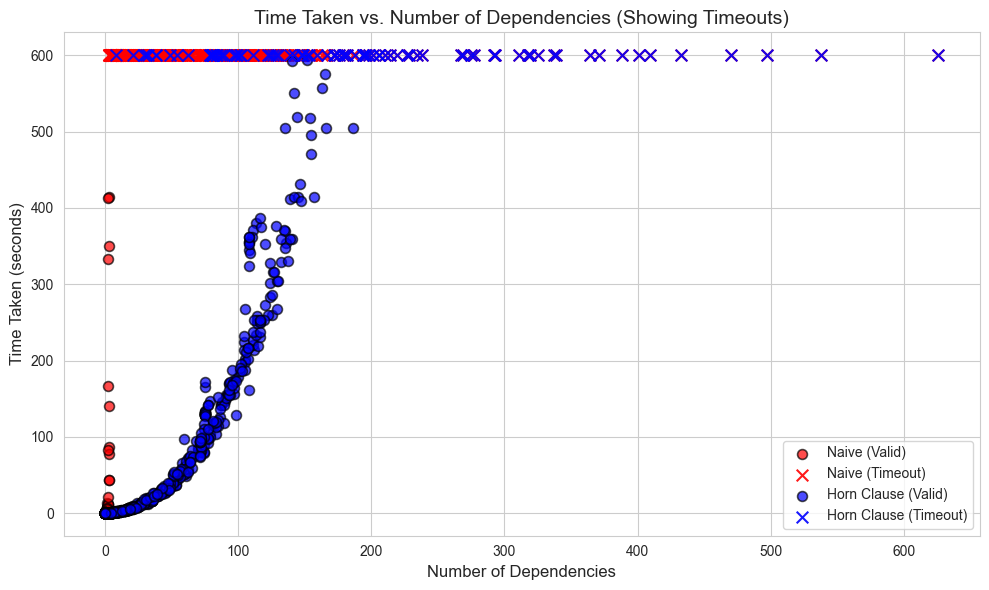

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------------------------
# 1. Parse JSON files for dependency counts
# ----------------------------------------------------------------------
CACHE_DIR = "logs/cache"  # Adjust path if needed
rows = []
failed_files = []  # List to hold names of JSON files that failed to parse

for filename in os.listdir(CACHE_DIR):
    if not filename.endswith(".json"):
        continue  # Skip non-JSON files
    path = os.path.join(CACHE_DIR, filename)
    
    # Assume filename format: "crate_name-version.json"
    base = filename[:-5]  # Remove ".json"
    if "-" in base:
        crate_name, crate_version = base.rsplit("-", 1)
    else:
        crate_name = base
        crate_version = "0.0.0"
    
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"JSON decode error in file {filename}: {e}")
        failed_files.append(filename)
        continue  # Skip this file
    
    # Get the dependency list and count them
    deps = data.get("dependencies", [])
    dep_count = len(deps)
    
    rows.append({
        "crate_name": crate_name,
        "version": crate_version,
        "dependency_count": dep_count
    })

df_deps = pd.DataFrame(rows)
print("Dependency counts extracted:")
print(df_deps.head())
if failed_files:
    print("The following files failed to parse and were skipped:")
    for f in failed_files:
        print(f)

# ----------------------------------------------------------------------
# 2. Read timing CSV files for two algorithms (with possible "timeout" values)
# ----------------------------------------------------------------------
df_basic = pd.read_csv("execution_timebasic_timeout.csv", dtype=str)
df_basic = df_basic.rename(columns={"time_taken": "time_basic"})

df_horn = pd.read_csv("execution_timeHorn_timeout.csv", dtype=str)
df_horn = df_horn.rename(columns={"time_taken": "time_horn"})

# ----------------------------------------------------------------------
# 3. Merge timing data and dependency counts
# ----------------------------------------------------------------------
df_times = pd.merge(df_basic, df_horn, on=["crate_name", "version"], how="outer")
df_merged = pd.merge(df_times, df_deps, on=["crate_name", "version"], how="left")

# Optional: save merged data
df_merged.to_csv("data_with_deps_and_times_new.csv", index=False)
print("Merged data saved to data_with_deps_and_times_new.csv")
print(df_merged.head())

# ----------------------------------------------------------------------
# 4. Define helpers to check file line counts and determine timeouts
# ----------------------------------------------------------------------
NAIVE_DIR = "evaluation/rq4"             # Directory for Naive approach files
HORN_DIR = os.path.join("evaluation", "rq3", "random1000")  # Directory for Horn Clause files

def file_line_count(directory, crate_name, version):
    """
    Returns the number of lines in the corresponding file, or 0 if file does not exist.
    """
    filename = f"{crate_name}-{version}"
    file_path = os.path.join(directory, filename)
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            return len(f.readlines())
    return 0

def is_naive_timeout(row):
    """
    Determines if the Naive approach (time_basic) is a timeout.
    Conditions for timeout:
    1) CSV says "timeout", OR
    2) The file in NAIVE_DIR does not exist or has <= 1 line
    """
    if str(row["time_basic"]).strip().lower() == "timeout":
        return True
    
    line_count = file_line_count(NAIVE_DIR, row["crate_name"], row["version"])
    if line_count <= 1:
        return True
    
    # If numeric, check for any other custom condition if needed
    # Otherwise, not a timeout
    return False

def is_horn_timeout(row):
    """
    Determines if the Horn approach (time_horn) is a timeout.
    Conditions for timeout:
    1) CSV says "timeout", OR
    2) The file in HORN_DIR does not exist or has <= 1 line
    """
    if str(row["time_horn"]).strip().lower() == "timeout":
        return True
    
    line_count = file_line_count(HORN_DIR, row["crate_name"], row["version"])
    if line_count <= 1:
        return True
    
    return False

# ----------------------------------------------------------------------
# 5. Apply the timeout checks and create numeric columns for valid times
# ----------------------------------------------------------------------
df_merged["naive_timeout"] = df_merged.apply(is_naive_timeout, axis=1)
df_merged["horn_timeout"]  = df_merged.apply(is_horn_timeout,  axis=1)

# Convert valid times to numeric, turn anything else into NaN
df_merged["time_basic_numeric"] = pd.to_numeric(df_merged["time_basic"], errors='coerce')
df_merged["time_horn_numeric"]  = pd.to_numeric(df_merged["time_horn"],  errors='coerce')

# For plotting, assign a fixed value (e.g., 600) to timeouts
TIMEOUT_VALUE = 600
df_merged["time_basic_plot"] = np.where(df_merged["naive_timeout"],
                                        TIMEOUT_VALUE,
                                        df_merged["time_basic_numeric"])
df_merged["time_horn_plot"] = np.where(df_merged["horn_timeout"],
                                       TIMEOUT_VALUE,
                                       df_merged["time_horn_numeric"])

# ----------------------------------------------------------------------
# 6. Split into subsets for plotting
# ----------------------------------------------------------------------
# Naive approach:
df_naive_valid   = df_merged[~df_merged["naive_timeout"] & df_merged["time_basic_numeric"].notna()].copy()
df_naive_timeout = df_merged[df_merged["naive_timeout"]].copy()

# Horn approach:
df_horn_valid   = df_merged[~df_merged["horn_timeout"] & df_merged["time_horn_numeric"].notna()].copy()
df_horn_timeout = df_merged[df_merged["horn_timeout"]].copy()

# ----------------------------------------------------------------------
# 7. Plot: Show timeouts as crosses, valid times as circles
# ----------------------------------------------------------------------
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,6))

# Naive valid (red circles)
ax.scatter(
    df_naive_valid["dependency_count"],
    df_naive_valid["time_basic_numeric"],
    color="red",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Naive (Valid)"
)

# Naive timeout (red crosses)
ax.scatter(
    df_naive_timeout["dependency_count"],
    df_naive_timeout["time_basic_plot"],
    color="red",
    alpha=0.9,
    marker="x",
    s=70,
    label="Naive (Timeout)"
)

# Horn valid (blue circles)
ax.scatter(
    df_horn_valid["dependency_count"],
    df_horn_valid["time_horn_numeric"],
    color="blue",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Horn Clause (Valid)"
)

# Horn timeout (blue crosses)
ax.scatter(
    df_horn_timeout["dependency_count"],
    df_horn_timeout["time_horn_plot"],
    color="blue",
    alpha=0.9,
    marker="x",
    s=70,
    label="Horn Clause (Timeout)"
)

ax.set_xlabel("Number of Dependencies", fontsize=12)
ax.set_ylabel("Time Taken (seconds)", fontsize=12)
ax.set_title("Time Taken vs. Number of Dependencies (Showing Timeouts)", fontsize=14)
ax.legend()

plt.tight_layout()
plt.savefig("/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq4/scatter_new.pdf", bbox_inches="tight")
plt.show()
